## Fatbox for numerical modelling - extraction

The following IPython notebook detail the workflow used to **extract fault** in the **numerical modelling** application of Fatbox paper. The process is the same used by Derek Neuharth in his study (he kindly agreed for the diffusion of the code).

The 2D continental rifting model was made using the geodynamic code ASPECT coupled to the landscape evolution code FastScape. This model simulates a continental rift while incorporating sedimentation and erosion processes.

In this workflow we use strain data from the cross section view of the model. We show how to **extract the faults** using Fatbox.
This is tutorial 1 of the numerical modelling application.

Neuharth, D., Brune, S., Wrona, T., Glerum, A., Braun, J., & Yuan, X. (2022). Evolution of rift systems and their fault networks in response to surface processes. Tectonics, 41, e2021TC007166. https://doi.org/10.1029/2021TC007166

To use this tutorial in Google Drive, you need to download Fatbox *modules* folder in your personal Drive. Then we build the access to it.

In [ ]:
# COMMENT IF RUNNING OUTSIDE GOOGLE COLAB

from google.colab import drive
drive.mount('/content/drive')
!pwd

Mounted at /content/drive
/content


In [ ]:
# COMMENT IF RUNNING OUTSIDE GOOGLE COLAB
!pip install earthpy
!pip install cv-algorithms
!pip install vtk

  Using cached earthpy-0.9.4-py3-none-any.whl.metadata (9.2 kB)
  Using cached rasterio-1.4.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.1 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1.2-py2.py3-none-any.whl.metadata (6.5 kB)
Using cached earthpy-0.9.4-py3-none-any.whl (1.4 MB)
Using cached rasterio-1.4.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (22.2 MB)
Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
Using cached affine-2.4.0-py3-none-any.whl (15 kB)
Using cached click_plugins-1.1.1.2-py2.py3-none-any.whl (11 kB)


Now we can start the libraries imports

In [ ]:
# Basic imports
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pickle
from scipy.spatial import distance_matrix
import pandas as pandas
import math
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from pathlib import Path
import os

from joblib import Parallel, delayed
import multiprocessing
import cv2
import timeit

#Paste your own directory
path_folder=Path('/content/drive/MyDrive/Fatbox')
path_modules=path_folder/'modules'
os.chdir(path_modules) # make modules as working directory
# on colab in a new cell: print(path_modules) #make sure path_modules = '/Fatbox/modules'
# on you IDE: type pwd in console and make sure it is '/Fatbox/modules'

# Fatbox import
import preprocessing
import metrics
import plots
import utils
import structural_analysis
import edits


data_path=Path(path_folder)/'tutorials'/'num'/'data_num'

save_path=Path(path_folder)/'tutorials'/'num'/'plots_num'

array_path=Path(path_folder)/'tutorials'/'num'/'array_num'

Let's start by setting the parameters.

In [ ]:
# Data from parameter file (=bash file) of the model
# endtime=0      # in myr, 0 will take last available time
# starttime=0.015  # in myr 0.015
x_pixels=2880
xlength=450  # in km
y_pixels=448 # in km
strain_rate_factor=0.1
minimum_distance=1.5
num_proc=12 # number of processor or the computer if using parallelisation
min_fault_length=1.5       # in km
scale = xlength/x_pixels


Extraction on a single cell to show the steps.

Remove triangles: 100%|██████████| 6/6 [00:00<00:00, 937.34it/s]


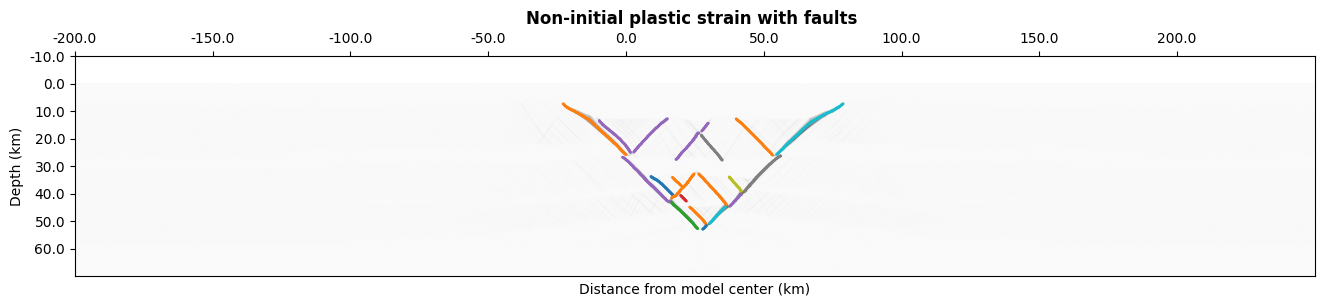

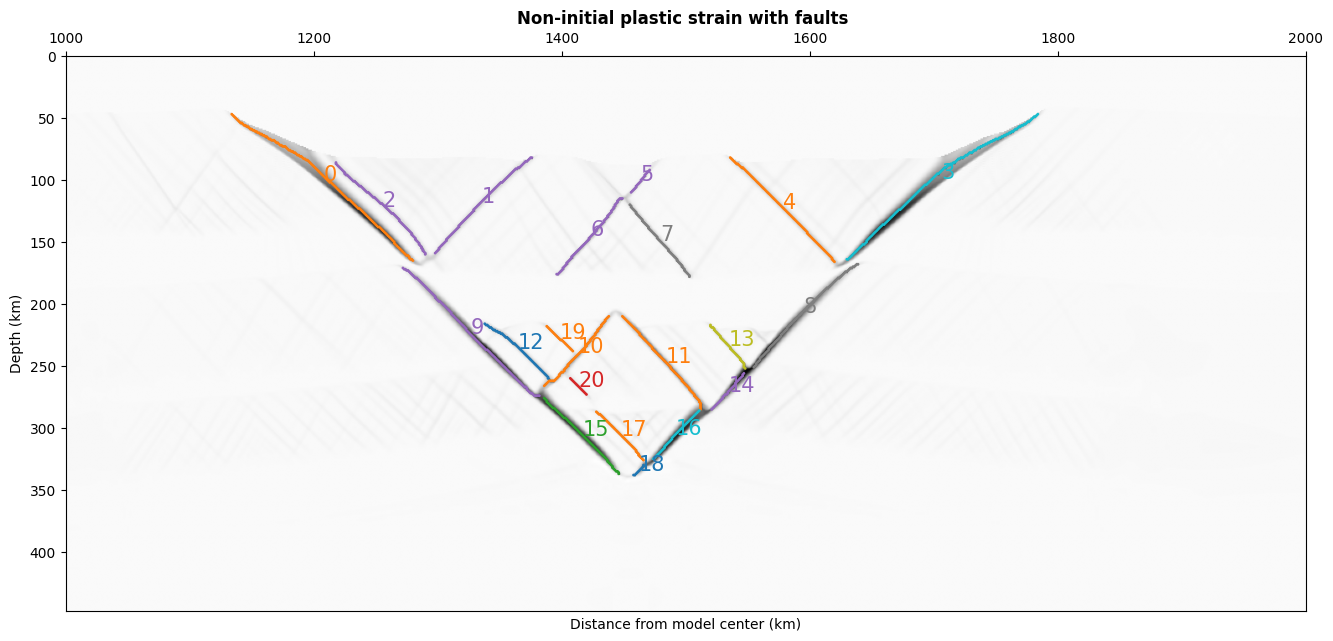

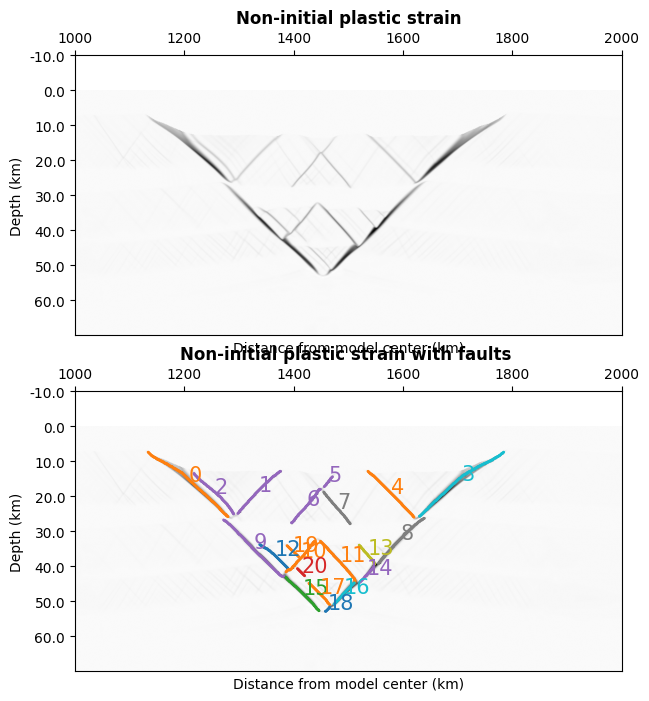

In [ ]:
#Let's take a single tiem step. Here data_300 correspond to 3My after the initiation of the rifting
pathcsv=Path(data_path)/'data_300.csv'

### Load timestep data from csv file.
data = pandas.read_csv(pathcsv, delimiter=',')

# Get positions for fields we need.
nps_pos = data.columns.get_loc("noninitial_plastic_strain")

# Convert pandas to numpy.
data = data.to_numpy()
data = np.flip(data, axis=0)

non_strain = data[:,nps_pos].reshape(y_pixels, x_pixels)
non_strain = np.flip(non_strain, axis=1)

non_strain_threshold = np.nanmax(non_strain)*strain_rate_factor #definition strain threshold

# We use a threshold for when values are below 1, and also take anything above our maximum weakening interval.
max_weak_interval = 1
threshold = np.where(np.logical_or(non_strain >= non_strain_threshold, non_strain >= max_weak_interval), 1, 0).astype(np.uint8)

##########################################################################

# SKELETONIZE - reduce the width of faults to a single pixel.
skeleton = preprocessing.skeleton_guo_hall(threshold)

#Connect components
ret, markers = cv2.connectedComponents(skeleton)

#Creation of the Graph
G = nx.Graph()

# First, we add the points as nodes and set their information.
node = 0
for comp in range(1,ret):

    # Why do we transpose
    points = np.transpose(np.vstack((np.where(markers==comp))))

    for point in points:
        # Add a node to correspond to the point.
        G.add_node(node)
        # Set the position data.
        G.nodes[node]['pos'] = (point[1], point[0])
        G.nodes[node]['x'] = G.nodes[node]['pos'][0]
        G.nodes[node]['y'] = G.nodes[node]['pos'][1]
        G.nodes[node]['z'] = 0
        # Set the fault label.
        G.nodes[node]['component'] = comp

        # The next point is set as the next node.
        node += 1


# Next we add the edges between these points.
for comp in range(1,ret):

    # Add point data for nodes that are connected (fault label).
    points = [G.nodes[node]['pos'] for node in G if G.nodes[node]['component']==comp]
    # Add corresponding node numbers.
    nodes  = [node for node in G if G.nodes[node]['component']==comp]

    # Find the distance between points to see if they are the same fault.
    dm = distance_matrix(points, points)

    for n in range(len(points)):
        for m in range(len(points)):
            # Determine which nodes are actually connected.
            if dm[n,m]<minimum_distance:
                G.add_edge(nodes[n],nodes[m])

#Improve the graph
G = metrics.compute_edge_length(G)

G = edits.remove_self_edge(G)

G = edits.label_components(G)

G = edits.remove_triangles(G)

G = edits.split_triple_junctions(G, 8, split='minimum', threshold=20, plot=False)

# Remove any faults below a certain size.
rsc = round(min_fault_length/scale)    # Convert length to pixels.
G = edits.remove_small_components(G, minimum_size = rsc)

G = edits.label_components(G)

G = calculate_dip(G, 5)


dof = 5
for node in G:
    neighbors = nx.single_source_shortest_path_length(G, node, cutoff=dof)
    dips = [G.nodes[node]['dip'] for node in neighbors.keys()]
    G.nodes[node]['max_diff'] = np.max(np.diff(dips))
    G.nodes[node]['cut'] = False


removals = []
for node in G:
    if G.nodes[node]['max_diff'] > 60:
        removals.append(node)


G.remove_nodes_from(removals)

# Remove any faults below a certain size.
rsc = round(min_fault_length/scale)    # Convert length to pixels.
G = edits.remove_small_components(G, minimum_size = rsc)

G = edits.label_components(G)

# PLOT 1: single csv
Gmaxx = x_pixels
Gminx = 0
Gmaxy = y_pixels
Gminy = 0

maxy = Gmaxy*scale#/1000
maxx = Gmaxx*scale#/1000
minx = Gminx*scale#/1000

xint = 5
if (maxx - minx) < 40:
    xint = 5
elif (maxx - minx) < 80:
    xint = 10
elif (maxx - minx) < 155:
    xint = 25
else:
    xint = 50

yint = 5
if (maxy + 10) < 35:
    yint = 5
else:
    yint = 10

# correct labels of the axis
xlab = np.array(np.zeros(math.floor((maxx-minx)/xint)))
xlab[len(xlab)//2] = math.ceil(minx/xint)*xint
for i in range(1, (len(xlab)//2)+1):
    xlab[(len(xlab)//2)-i]=-(xint*i)
    xlab[(len(xlab)//2)+i]=+(xint*i)

ylab = np.array(np.zeros(math.floor((maxy+10)/yint)))
ylab[0] = -10
for i in range(2, len(ylab)):
    ylab[i] = ylab[i-1] + yint


fig, axs = plt.subplots(1, 1, figsize=(16,8))
p = axs.imshow(non_strain, cmap='gray_r',aspect="equal")

plots.plot_components(G, label=False, ax=axs, node_size = 1)

listx_G=[]
for node in G.nodes:
    listx_G.append(G.nodes[node]['x'])

axs.set_xlim([Gminx, Gmaxx])
#axs.set_xlim([1000, 2000])
axs.set_ylim([Gmaxy, 0])
#axs[0].set_title('Non-initial plastic strain, Time: ' + str(title_time) + ' Myr, File:' +str(file), fontweight='bold')
axs.set_title('Non-initial plastic strain with faults ', fontweight='bold')
axs.set_ylabel('Depth (km)')
axs.set_xlabel('Distance from model center (km)')
axs.xaxis.tick_top()

locs_y=ylab/scale #locs in pixels of the labels.
plt.yticks(locs_y,ylab)

locs_x=(xlab+max(xlab))/scale
plt.xticks(locs_x,xlab)

## PLOT 2
Gmaxx = x_pixels
Gminx = 0
Gmaxy = y_pixels
Gminy = 0

maxy = Gmaxy*scale#/1000
maxx = Gmaxx*scale#/1000
minx = Gminx*scale#/1000

xint = 5
if (maxx - minx) < 40:
    xint = 5
elif (maxx - minx) < 80:
    xint = 10
elif (maxx - minx) < 155:
    xint = 25
else:
    xint = 50

yint = 5
if (maxy + 10) < 35:
    yint = 5
else:
    yint = 10

# correct labels of the axis
xlab = np.array(np.zeros(math.floor((maxx-minx)/xint)))
xlab[len(xlab)//2] = math.ceil(minx/xint)*xint
for i in range(1, (len(xlab)//2)+1):
    xlab[(len(xlab)//2)-i]=-(xint*i)
    xlab[(len(xlab)//2)+i]=+(xint*i)

ylab = np.array(np.zeros(math.floor((maxy+10)/yint)))
ylab[0] = -10
for i in range(2, len(ylab)):
    ylab[i] = ylab[i-1] + yint


fig, axs = plt.subplots(1, 1, figsize=(16,8))
p = axs.imshow(non_strain, cmap='gray_r',aspect="equal")

plots.plot_components(G, label=True, ax=axs, node_size = 1)

listx_G=[]
for node in G.nodes:
    listx_G.append(G.nodes[node]['x'])

#axs.set_xlim([Gminx, Gmaxx])
axs.set_xlim([1000, 2000])
axs.set_ylim([Gmaxy, 0])
#axs[0].set_title('Non-initial plastic strain, Time: ' + str(title_time) + ' Myr, File:' +str(file), fontweight='bold')
axs.set_title('Non-initial plastic strain with faults ', fontweight='bold')
axs.set_ylabel('Depth (km)')
axs.set_xlabel('Distance from model center (km)')
axs.xaxis.tick_top()

locs_y=ylab/scale #locs of the labels in pixels

locs_x=(xlab+max(xlab))/scale

## PLOT 3

fig, axs = plt.subplots(2, 1, figsize=(16,8))
axs[0].imshow(non_strain, cmap='gray_r',aspect="equal")
p = axs[1].imshow(non_strain, cmap='gray_r',aspect="equal")

plots.plot_components(G, label=True, ax=axs[1], node_size = 1)

listx_G=[]
for node in G.nodes:
    listx_G.append(G.nodes[node]['x'])

axs[0].set_xlim([1000, 2000])
axs[1].set_xlim([1000, 2000])
axs[1].set_ylim([Gmaxy, 0])
axs[0].set_ylim([Gmaxy, 0])

axs[0].set_title('Non-initial plastic strain',fontweight='bold')

axs[0].set_ylabel('Depth (km)')
axs[0].set_xlabel('Distance from model center (km)')

axs[1].set_title('Non-initial plastic strain with faults ', fontweight='bold')
axs[1].set_ylabel('Depth (km)')
axs[1].set_xlabel('Distance from model center (km)')

axs[1].xaxis.tick_top()
axs[0].xaxis.tick_top()

locs_y=ylab/scale #locs in pixels of the labels.
axs[0].set_yticks(locs_y,ylab)
axs[1].set_yticks(locs_y,ylab)

locs_x=(xlab+max(xlab))/scale

In a routine use, the extraction is a huge function as follow. It can then be executed in sequential or parallelized.

In [ ]:
start = timeit.default_timer()

### Function definitions ####
def calculate_dip(G, dof):
    for node in G:

        neighbors = nx.single_source_shortest_path_length(G, node, cutoff=dof)

        neighbors = sorted(neighbors.items())

        first = neighbors[0][0]
        last = neighbors[-1][0]

        x1 = G.nodes[first]['pos'][0]
        y1 = G.nodes[first]['pos'][1]

        x2 = G.nodes[last]['pos'][0]
        y2 = G.nodes[last]['pos'][1]

        G.nodes[node]['dip'] = structural_analysis.dip(x1, y1, x2, y2)

    return G
#############################

def extract_faults(file):

    #print(file)

    ### Load timestep data from csv file. Pandas seems to be fastest when using multiple cores.
    data = pandas.read_csv(str(data_path)+'/data_' + str(file) + '.csv', delimiter=',')

    # Get positions for fields we need.
    nps_pos = data.columns.get_loc("noninitial_plastic_strain")

    # Convert pandas to numpy.
    data = data.to_numpy()
    data = np.flip(data, axis=0)

    non_strain = data[:,nps_pos].reshape(y_pixels, x_pixels)
    non_strain = np.flip(non_strain, axis=1)

    non_strain_threshold = np.nanmax(non_strain)*strain_rate_factor

    # We use a threshold for when values are below 1, and also take anything above our maximum weakening interval.
    max_weak_interval = 1
    threshold = np.where(np.logical_or(non_strain >= non_strain_threshold, non_strain >= max_weak_interval), 1, 0).astype(np.uint8)
    #threshold = np.where(non_strain >= non_strain_threshold, 1, 0).astype(np.uint8)

    ##########################################################################

    # SKELETONIZE - reduce the width of faults to a single pixel.
    skeleton = preprocessing.skeleton_guo_hall(threshold)
    #plot_comparison([data, threshold, skeleton])

    #// How does this work?
    ret, markers = cv2.connectedComponents(skeleton)

    # The G graph holds our positive polarity info
    G = nx.Graph()

    # First, we add the points as nodes and set their information.
    node = 0
    for comp in range(1,ret):

        # Why do we transpose
        points = np.transpose(np.vstack((np.where(markers==comp))))

        for point in points:
            # Add a node to correspond to the point.
            G.add_node(node)
            # Set the position data.
            G.nodes[node]['pos'] = (point[1], point[0])
            G.nodes[node]['x'] = G.nodes[node]['pos'][0]
            G.nodes[node]['y'] = G.nodes[node]['pos'][1]
            G.nodes[node]['z'] = 0
            # Set the fault label.
            G.nodes[node]['component'] = comp

            # The next point is set as the next node.
            node += 1


    # Next we add the edges between these points.
    for comp in range(1,ret):

        # Add point data for nodes that are connected (fault label).
        points = [G.nodes[node]['pos'] for node in G if G.nodes[node]['component']==comp]
        # Add corresponding node numbers.
        nodes  = [node for node in G if G.nodes[node]['component']==comp]

        # Find the distance between points to see if they are the same fault.
        dm = distance_matrix(points, points)

        for n in range(len(points)):
            for m in range(len(points)):
                # Determine which nodes are actually connected.
                if dm[n,m]<minimum_distance:
                    G.add_edge(nodes[n],nodes[m])


    G = metrics.compute_edge_length(G)

    G = edits.remove_self_edge(G)

    G = edits.label_components(G)

    G = edits.remove_triangles(G)

    G = edits.split_triple_junctions(G, 8, split='minimum', threshold=20, plot=False)

    # Remove any faults below a certain size.
    rsc = round(min_fault_length/scale)    # Convert length to pixels.
    G = edits.remove_small_components(G, minimum_size = rsc)

    G = edits.label_components(G)

    G = calculate_dip(G, 5)

    # Threshold when removing.
    dof = 5
    for node in G:
        neighbors = nx.single_source_shortest_path_length(G, node, cutoff=dof)
        dips = [G.nodes[node]['dip'] for node in neighbors.keys()]
        G.nodes[node]['max_diff'] = np.max(np.diff(dips))
        G.nodes[node]['cut'] = False


    removals = []
    for node in G:
        if G.nodes[node]['max_diff'] > 60:
            removals.append(node)


    G.remove_nodes_from(removals)

    # Remove any faults below a certain size.
    rsc = round(min_fault_length/scale)    # Convert length to pixels.
    G = edits.remove_small_components(G, minimum_size = rsc)

    G = edits.label_components(G)

##### Plots #####

    Gmaxx = x_pixels
    Gminx = 0
    Gmaxy = y_pixels
    Gminy = 0

    maxy = Gmaxy*scale#/1000
    maxx = Gmaxx*scale#/1000
    minx = Gminx*scale#/1000

    xint = 5
    if (maxx - minx) < 40:
        xint = 5
    elif (maxx - minx) < 80:
        xint = 10
    elif (maxx - minx) < 155:
        xint = 25
    else:
        xint = 50

    yint = 5
    if (maxy + 10) < 35:
        yint = 5
    else:
        yint = 10

    # correct labels of the axis
    xlab = np.array(np.zeros(math.floor((maxx-minx)/xint)))
    xlab[len(xlab)//2] = math.ceil(minx/xint)*xint
    for i in range(1, (len(xlab)//2)+1):
        xlab[(len(xlab)//2)-i]=-(xint*i)
        xlab[(len(xlab)//2)+i]=+(xint*i)

    ylab = np.array(np.zeros(math.floor((maxy+10)/yint)))
    ylab[0] = -10
    for i in range(2, len(ylab)):
        ylab[i] = ylab[i-1] + yint


    fig, axs = plt.subplots(1, 1, figsize=(16,8))
    p = axs.imshow(non_strain, cmap='gray_r',aspect="equal")

    plots.plot_components(G, label=True, ax=axs, node_size = 1)

    listx_G=[]
    for node in G.nodes:
        listx_G.append(G.nodes[node]['x'])

    #axs.set_xlim([Gminx, Gmaxx])
    axs.set_xlim([1000, 2000])
    axs.set_ylim([Gmaxy, 0])
    #axs[0].set_title('Non-initial plastic strain, Time: ' + str(title_time) + ' Myr, File:' +str(file), fontweight='bold')
    axs.set_title('Non-initial plastic strain with faults ', fontweight='bold')
    axs.set_ylabel('Depth (km)')
    axs.set_xlabel('Distance from model center (km)')
    axs.xaxis.tick_top()

    locs_y=ylab/scale #locs of the labels in pixels
    #plt.yticks(locs_y,ylab)

    locs_x=(xlab+max(xlab))/scale
    #plt.xticks(locs_x,xlab)

    # Save figure as image to check that faults are being properly identified.
    plt.savefig(save_path / str(str(file).zfill(5) + '.png'), dpi=200)
    plt.close("all")


    fig, axs = plt.subplots(2, 1, figsize=(16,8))
    axs[0].imshow(non_strain, cmap='gray_r',aspect="equal")
    p = axs[1].imshow(non_strain, cmap='gray_r',aspect="equal")

    plots.plot_components(G, label=True, ax=axs[1], node_size = 1)

    listx_G=[]
    for node in G.nodes:
        listx_G.append(G.nodes[node]['x'])

    #axs[0].set_xlim([Gminx, Gmaxx])
    #axs[1].set_xlim([Gminx, Gmaxx])
    axs[0].set_xlim([1000, 2000])
    axs[1].set_xlim([1000, 2000])
    axs[1].set_ylim([Gmaxy, 0])
    axs[0].set_ylim([Gmaxy, 0])

    axs[0].set_title('Non-initial plastic strain',fontweight='bold')
    #axs[0].set_title('Non-initial plastic strain, Time: ' + str(title_time) + ' Myr, File:' +str(file), fontweight='bold')
    axs[0].set_ylabel('Depth (km)')
    axs[0].set_xlabel('Distance from model center (km)')

    axs[1].set_title('Non-initial plastic strain with faults ', fontweight='bold')
    axs[1].set_ylabel('Depth (km)')
    axs[1].set_xlabel('Distance from model center (km)')

    axs[1].xaxis.tick_top()
    axs[0].xaxis.tick_top()

    locs_y=ylab/scale #locs in pixels of the labels.
    axs[0].set_yticks(locs_y,ylab)
    axs[1].set_yticks(locs_y,ylab)

    locs_x=(xlab+max(xlab))/scale
    #axs[0].set_xticks(locs_x,xlab)
    #axs[1].set_xticks(locs_x,xlab)

    plt.savefig(save_path / str('double_plot' + str(file).zfill(5) + '.png'), dpi=200)


    pickle.dump(G, open( (array_path/str('G'+ str(file)+'.pickle')), 'wb')) #make sure the file name is unique

    return G ##

    # Save the pickle graph, which can be reloaded and contain all information
    # corresponding to the nodes and edges.
    # This data can later be viewed, after loading a graph using the command
    # name.nodes
    # Where name is the variable given to the loaded graph. This will display
    # all nodes associated with the graph. Then by asking for a number:
    # name.nodes[5]
    # you can see all information corresponding to that node.
    #pickle.dump(G, open('./graphs/pickle/g_' + str(file) + '.p', "wb" ))


Now we can execute the extraction

Remove triangles: 100%|██████████| 26/26 [00:00<00:00, 1026.87it/s]


Extract time:  3356.315251444


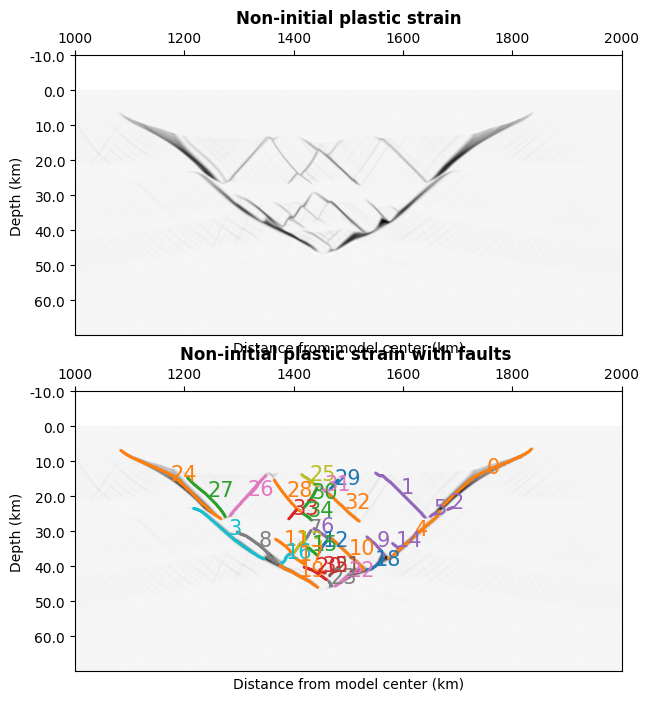

In [ ]:
# Instruction to execute in parallel the extraction of the time steps.
#
#num_cores = multiprocessing.cpu_count()-4
#results = Parallel(n_jobs=min(len(files), num_proc))(delayed(extract_faults)(file) for file in files)
#

# Start and End step. Unit is 10 000 years
start=200
end=450

G_dem=[]

for file in range(start, end+1, 50): #Increment set as 50 = 500 000y to show enough progress
    G=extract_faults(file)
    G_dem.append(G)

#multiprocessing.cpu_count()
stop = timeit.default_timer()

print('Extract time: ', stop - start)


Quick plots, you can use it to check your execution as a first step.

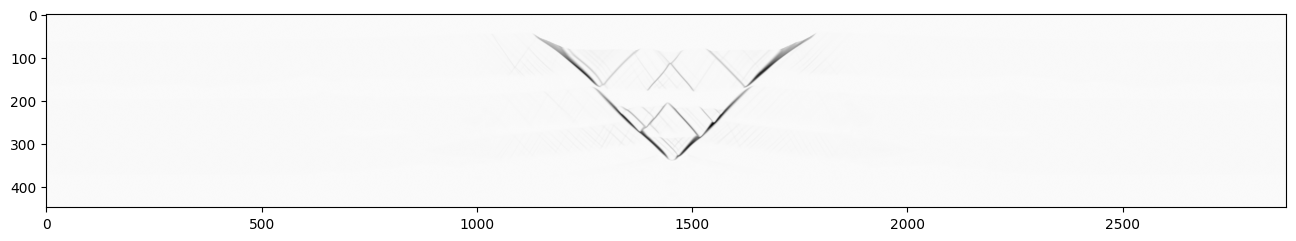

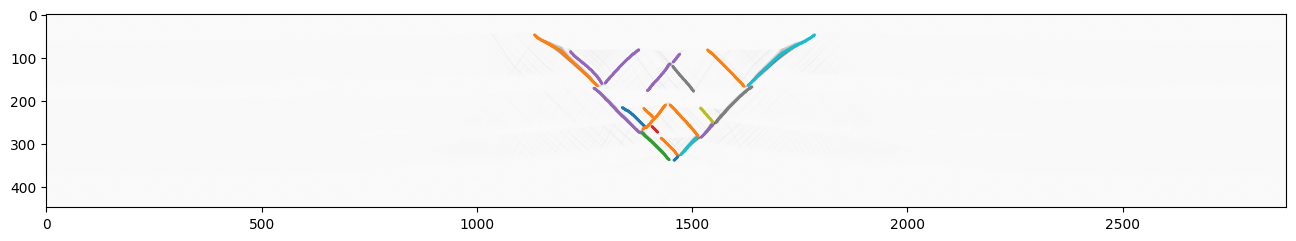

In [ ]:
# very simple plot strain

fig, axs = plt.subplots(1, 1, figsize=(16,8))

p = axs.imshow(non_strain, cmap='gray_r',aspect="equal")

# very simple plot strain and faults
fig, axs = plt.subplots(1, 1, figsize=(16,8))
p = axs.imshow(non_strain, cmap='gray_r',aspect="equal")

plots.plot_components(G, label=False, ax=axs, node_size = 1)

In summary, now we have for every time step independent Graph containing all the faults extracted.

You can now run the correlation tutorial. See you there!